In [116]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, roc_auc_score, f1_score,
    confusion_matrix, classification_report, RocCurveDisplay
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier # 배깅

from xgboost import XGBClassifier # 부스팅
from catboost import CatBoostClassifier, Pool # 부스팅, 2018년


In [117]:
#! pip install xgboost
#! pip install catboost

In [118]:
# 1) 데이터 로딩
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")  # 0=malignant, 1=benign

In [119]:
print("Shape:", X.shape)
print("Target counts:\n", y.value_counts(), "\n")


Shape: (569, 30)
Target counts:
 target
1    357
0    212
Name: count, dtype: int64 



In [120]:
# 메디컬 데이터 -> 데이터 개수가 적은편이 많다
# 메디컬 데이터 극악 데이터 중 하나 -> 질병이 존재하는 사람이 그렇지 않은 사람에 비해서 확실히 적다
# 메디컬 데이터 분석 -> 데이터 불균형(class imbalance), 데이터 증강이 필요할수도?
# 메디컬 데이터 규제 심하고 공개 잘 안되어 있어서 -> 항상 법과 규제에 막히는 일이 많다
# 어렵습니다 -> 메디컬 데이터의 도메인이....

In [121]:
 X

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [122]:
y

0      0
1      0
2      0
3      0
4      0
      ..
564    0
565    0
566    0
567    0
568    1
Name: target, Length: 569, dtype: int32

In [123]:
y[y==1]

19     1
20     1
21     1
37     1
46     1
      ..
558    1
559    1
560    1
561    1
568    1
Name: target, Length: 357, dtype: int32

In [124]:
# 2) 간단 EDA
print("Head:\n", X.head(3), "\n")
print("Describe (mean/std/min/25/50/75/max):\n", X.describe().T.iloc[:6, :], "\n")
print("결측치 개수 :\n", X.isna().sum().sort_values(ascending=False), "\n")

Head:
    mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38           122.8     1001.0          0.11840   
1        20.57         17.77           132.9     1326.0          0.08474   
2        19.69         21.25           130.0     1203.0          0.10960   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   

   mean fractal dimension  ...  worst radius  worst texture  worst perimeter  \
0                 0.07871  ...         25.38          17.33            184.6   
1                 0.05667  ...         24.99          23.41            158.8   
2                 0.05999  ...         23.57          25.53            152.5   

   worst area  worst smoothness  worst compactness  worst concavit

In [125]:
# 가설검정을 왜 했냐? 여러분들이 데이터를 처음 받은 상황에서 데이터 정보, 인사이트, 신뢰가 없는상황
# 내가 수집에 관여했고 데이터 도메인 짱이다 -> 믿음으로 가도 되는데
# 아직 그게 없는 상황에서는 돌다리도 두드려 보고 거넌가야 한다
# + 나중에 머신러닝 결과해석할때 풍부하게 해석할 수 있다

In [126]:
# 3) 가설검정: 악성(0) vs 양성(1) mean radius 차이 (Welch t-test, Mann–Whitney)
m = X.loc[y == 0, "mean radius"]
b = X.loc[y == 1, "mean radius"]
t_stat, p_t = stats.ttest_ind(m, b, equal_var=False)
u_stat, p_u = stats.mannwhitneyu(m, b, alternative="two-sided")
print("[Welch t-test] 'mean radius' | t=%.3f, p=%.2e" % (t_stat, p_t))
print("[Mann–Whitney U] 'mean radius' | U=%.1f, p=%.2e\n" % (u_stat, p_u))

[Welch t-test] 'mean radius' | t=22.209, p=1.68e-64
[Mann–Whitney U] 'mean radius' | U=70955.0, p=2.69e-68



In [127]:
# 가설검정을해서 혹시 유의미하게 나오지 않은 변수가 있다면 제거해도 되겠네 (변수선택) -> 신중하게 생각해야!
# 단변량만 본것 (mean radius가 양성 악성 차이나는 거 확실하다! -> 만약에 mean radius가 양성 악성 차이가 안나는것같다면? -> 변수제거하면...
# 실제로는 다련 변수들과 관련이 되서 양성, 악성에 영향을 줄 수도 있어요!

In [128]:
# 4) 학습/평가 (간단 설정)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
# 이것도 하나 얘기드릴게
# 사실 test 데이터를 미리 따로 빼놓고 (데이터 전처리, 가설검정 이런거 하기전에 하면 더 좋긴 해야)
# 왜 test 데이터는 우리가 분석하기 따로 빼놓는것이 사실 더 권장이 될까요? -> 우리가 전처리하면서 test에 대한 인사이트가 생길까봐


models = {
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1),
    "XGBoost" : XGBClassifier(
        n_estimators=300, max_depth=4, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.8, eval_metric="auc",
        n_jobs=-1, random_state=42
    ),
    "CatBoost" : CatBoostClassifier(
        iterations=400, depth=4, learning_rate=0.05,
        loss_function="Logloss", eval_metric="AUC",
        verbose=False, random_state=42)
}

## RandomForestClassifier
### 코드에 있는 파라미터

- n_estimators=300: 트리 개수. 많을수록 보통 성능↑·분산↓(시간/메모리↑). 200~1000 사이에서 탐색.

- random_state=42: 난수 고정(재현성).

- n_jobs=-1: CPU 코어 전부 사용(학습/예측 병렬화).

### 추가로 자주 조정하는 파라미터

- max_depth: 트리 최대 깊이. 작게 하면 과적합↓(편향↑).

- min_samples_split, min_samples_leaf: 분할/리프 최소 표본 수. 값을 키우면 과적합↓, 경계가 매끈해짐.

- max_features: 각 분할에서 고려할 특성 수(기본값='sqrt' for 분류). 작게 하면 트리 간 상관↓ → 앙상블 효과↑.

- bootstrap(기본=True): 부트스트랩 샘플로 각 트리 학습. False면 배깅과 달라져 과적합↑ 위험.

- class_weight='balanced': 클래스 불균형 보정.

- oob_score=True: Out-of-bag 점수로 검증(별도 검증셋 없이 대략적인 성능 확인).

- criterion: 분할 기준(‘gini’, ‘entropy’, ‘log_loss’). 큰 차이는 없지만 데이터에 따라 미세한 변화 가능.

- ccp_alpha: 비용-복잡도 전정 파라미터(>0이면 트리 가지치기, 과적합↓).

## XGBClassifier (XGBoost)
### 코드에 있는 것

- n_estimators=300: 부스팅 단계 수(트리 수).

- max_depth=4: 개별 트리 깊이(깊을수록 복잡도↑, 과적합 위험↑).

- learning_rate=0.05: 학습률(작을수록 한 스텝 영향↓ → 더 많은 트리 필요하지만 일반화에 유리).

- subsample=0.9: 샘플 서브샘플링 비율(무작위성으로 과적합↓).

- colsample_bytree=0.8: 트리마다 특성 서브샘플링 비율(무작위성↑, 과적합↓).

- eval_metric="auc": 평가 지표(분류에서 보통 ‘auc’, ‘logloss’, ‘error’ 등 사용).

- n_jobs=-1: 병렬 스레드 수.

- random_state=42: 재현성.

### 추가로 자주 조정하는 파라미터

- min_child_weight: 자식 노드에 필요한 최소 가중치 합(= 최소 자료량). 값↑ → 분할 보수적(과적합↓).

- gamma: 분할로 얻어야 하는 최소 손실 감소. 값↑ → 분할 보수적.

- reg_lambda(=lambda), reg_alpha(=alpha): L2/L1 정규화(가중치 규제, 과적합↓).

- colsample_bylevel, colsample_bynode: 레벨/노드 단위의 특성 서브샘플링.

- objective: 손실 함수(예: ‘binary:logistic’, ‘multi:softprob’ 등).

- tree_method: ‘hist’(기본) 혹은 'gpu_hist'(GPU 사용). 속도/스케일에 중요.

- max_bin: 히스토그램 bin 수(‘hist’에서 연속형 분할 정밀도/속도 트레이드오프).

- grow_policy: ‘depthwise’(기본) / ‘lossguide’(리프 지향, 희소·대규모 데이터에서 유리할 때 있음).

- scale_pos_weight: 양성/음성 불균형 보정(≈ 음성/양성 비율).

- early_stopping_rounds (fit 인자): 검증셋에서 개선 없으면 조기 종료(학습 시간↓, 과적합↓).

- eval_set (fit 인자): 조기종료/모니터링용 검증셋 지정.


## CatBoostClassifier
### 코드에 있는 것

- iterations=400: 부스팅 단계 수.

- depth=4: 트리 깊이.

- learning_rate=0.05: 학습률.

- loss_function="Logloss": 이진 분류 기본 손실.

- eval_metric="AUC": 평가 지표.

- verbose=False: 로그 표시 끔.

- random_state=42: 재현성.

### 자주 추가로 조정하는 파라미터

- l2_leaf_reg: 리프 가중치 L2 정규화(과적합↓).

- bagging_temperature: 샘플링 무작위성 강도(높을수록 다양성↑, 과적합↓ 경향).

- random_strength: 분할 후보 점수에 랜덤성 추가(작으면 결정적, 크면 무작위성↑).

- rsm: 특성 서브샘플링 비율(= XGBoost의 colsample_* 유사).

- border_count / max_bin: 연속형 특성의 구간 수(정밀도↔속도/과적합 트레이드오프).

- bootstrap_type: ‘Bayesian’, ‘Bernoulli’, ‘MVS’ 등 배깅 방식.

- leaf_estimation_iterations / method: 리프 값 추정 반복/방법(‘Newton’/‘Gradient’).

- class_weights 또는 auto_class_weights: 불균형 보정.

- scale_pos_weight: 불균형 보정(양성 클래스 가중).

- od_type / od_wait: Overfitting Detector(조기 종료) 설정.

- task_type="GPU", devices: GPU 학습.

- cat_features: 범주형 컬럼 인덱스/이름 지정(타깃 통계·Ordered boosting 기법으로 자동 처리).


=== DecisionTree ===
Accuracy: 0.9123
ROC-AUC : 0.9157
Confusion Matrix:
 [[39  3]
 [ 7 65]]

=== RandomForest ===
Accuracy: 0.9474
ROC-AUC : 0.9937
Confusion Matrix:
 [[39  3]
 [ 3 69]]

=== XGBoost ===
Accuracy: 0.9561
ROC-AUC : 0.9957
Confusion Matrix:
 [[38  4]
 [ 1 71]]

=== CatBoost ===
Accuracy: 0.9561
ROC-AUC : 0.9947
Confusion Matrix:
 [[39  3]
 [ 2 70]]


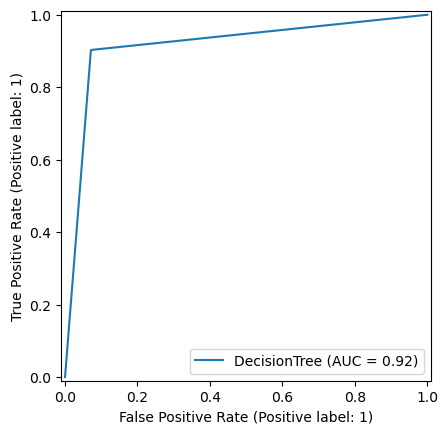

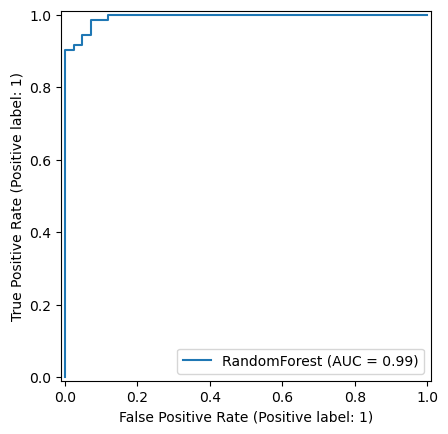

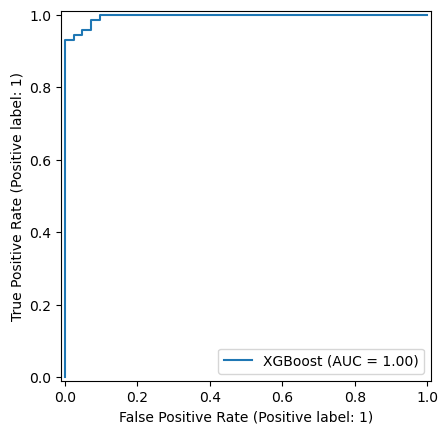

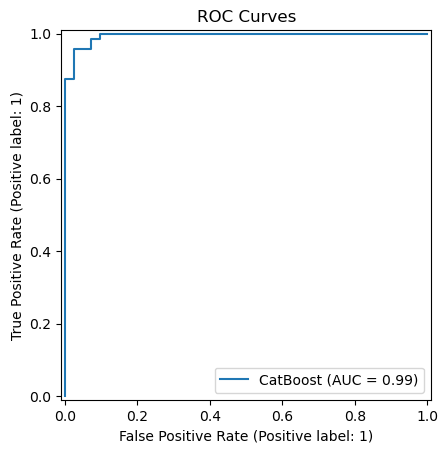

In [129]:
summary = []
for name, clf in models.items():
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    proba = clf.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, pred)
    roc = roc_auc_score(y_test, proba)
    summary.append([name, acc, roc])

    print(f"\n=== {name} ===")
    print("Accuracy:", round(acc, 4))
    print("ROC-AUC :", "N/A" if np.isnan(roc) else round(roc, 4))
    print("Confusion Matrix:\n", confusion_matrix(y_test, pred))

    if proba is not None:
        RocCurveDisplay.from_predictions(y_test, proba, name=name)

plt.title("ROC Curves")
plt.show()

### 클래스 불균형 (class imbalance)
- 클래스가 극단적으로 개수 차이가 발생할 때 ex) 양성 10, 음성 1000개
- 이런 상황에서 accuracy쓴다는 것은 말이 안됌! -> 왜죠? 개수가 많은 클래스 때문에 성능이 높게 나올 수 있어서
- recall, precision, f1-score, auc

In [130]:
# 5) 요약표 + 간단 Feature Importance (RF 상위 10개)
sum_df = pd.DataFrame(summary, columns=["model", "accuracy", "roc_auc"]).sort_values("roc_auc", ascending=False)
print("\n== Summary ==")
print(sum_df)


== Summary ==
          model  accuracy   roc_auc
2       XGBoost  0.956140  0.995701
3      CatBoost  0.956140  0.994709
1  RandomForest  0.947368  0.993717
0  DecisionTree  0.912281  0.915675


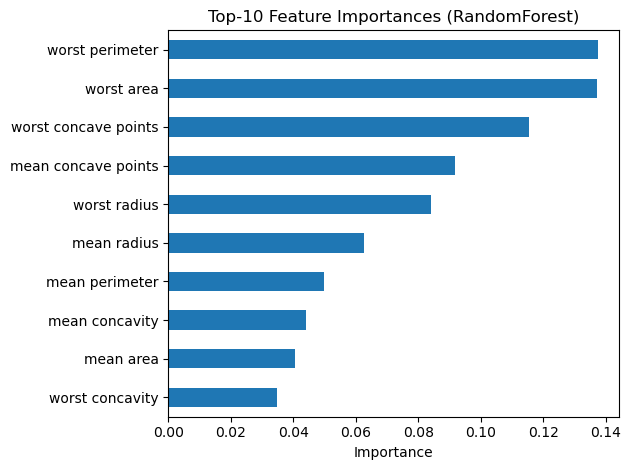

In [131]:
rf = models.get("RandomForest")
if rf is not None and hasattr(rf, "feature_importances_"):
    fi = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)[:10]
    ax = fi.iloc[::-1].plot(kind="barh")
    ax.set_title("Top-10 Feature Importances (RandomForest)")
    ax.set_xlabel("Importance")
    plt.tight_layout()
    plt.show()

In [132]:
rf.feature_importances_

array([0.0627415 , 0.01338028, 0.04967965, 0.04050752, 0.0062723 ,
       0.01814101, 0.0441424 , 0.09177421, 0.00511955, 0.00423616,
       0.01793089, 0.00447044, 0.00747672, 0.03361319, 0.00448859,
       0.00433066, 0.00581806, 0.00464022, 0.00478081, 0.00478757,
       0.08411075, 0.01869436, 0.13734428, 0.13731177, 0.01376366,
       0.01445104, 0.03483704, 0.11550197, 0.00895883, 0.00669458])

# catboost를 범주형 데이터에 사용한 예시

In [133]:
# 1) 예시 데이터 (범주형 3개 + 수치 2개)
rng = np.random.default_rng(42)
n = 1000
df = pd.DataFrame({
    "city":   rng.choice(["Seoul","Busan","Daegu","Incheon","Gwangju","Ulsan","Sejong"], size=n),
    "device": rng.choice(["ios","android"], size=n, p=[0.45, 0.55]),
    "plan":   rng.choice(["basic","premium"], size=n, p=[0.6, 0.4]),
    "age":    rng.integers(18, 66, size=n),
    "sessions7d": rng.poisson(5, size=n),
})

# 타깃 생성(일부 규칙 + 노이즈) : basic & android & 세션 적으면 이탈(churn=1) 성향
y = (
    (df["plan"].eq("basic")) &
    (df["device"].eq("android")) &
    (df["sessions7d"] < 4)
).astype(int)
y = y.where(rng.random(n) > 0.15, 1 - y)  # 15% 노이즈


In [134]:
df

,city,device,plan,age,sessions7d
0,Seoul,android,premium,27,5
1,Ulsan,android,premium,19,2
2,Gwangju,android,basic,48,8
3,Incheon,android,basic,50,5
4,Incheon,android,premium,55,4
...,...,...,...,...,...
995,Gwangju,android,basic,28,5
996,Incheon,android,basic,59,3
997,Daegu,android,basic,65,6
998,Sejong,ios,premium,54,6


In [135]:
X_train, X_test, y_train, y_test = train_test_split(
    df, y, test_size=0.2, stratify=y, random_state=42
)

In [136]:
# 2) 범주형 컬럼 지정 (이름 또는 인덱스 사용 가능)
cat_cols = ["city", "device", "plan"]

In [142]:
model = CatBoostClassifier(
    iterations=300, depth=4, learning_rate=0.1,
    loss_function="Logloss", eval_metric="AUC",
    verbose=False, random_state=42, task_type='GPU'
)

# Pool로 감싸는 방법 -> 이왕이면 이걸 사용하면 좋다
train_pool = Pool(X_train, y_train, cat_features=cat_cols)
test_pool  = Pool(X_test,  y_test,  cat_features=cat_cols)

model.fit(train_pool, eval_set=test_pool, verbose=100)

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4792490	best: 0.4792490 (0)	total: 28.2ms	remaining: 8.45s
100:	test: 0.5530774	best: 0.5647939 (50)	total: 1.26s	remaining: 2.48s
200:	test: 0.5365613	best: 0.5647939 (50)	total: 2.17s	remaining: 1.07s
299:	test: 0.5437606	best: 0.5647939 (50)	total: 3.18s	remaining: 0us
bestTest = 0.5647938848
bestIteration = 50
Shrink model to first 51 iterations.


In [138]:
# 4) 평가
pred = model.predict(X_test)               # 클래스(0/1)
proba = model.predict_proba(X_test)[:, 1]  # 양성 확률
print("Accuracy:", round(accuracy_score(y_test, pred), 4))
print(classification_report(y_test, pred, digits=4))

Accuracy: 0.815
              precision    recall  f1-score   support

           0     0.8095    0.9935    0.8921       154
           1     0.9091    0.2174    0.3509        46

    accuracy                         0.8150       200
   macro avg     0.8593    0.6054    0.6215       200
weighted avg     0.8324    0.8150    0.7676       200



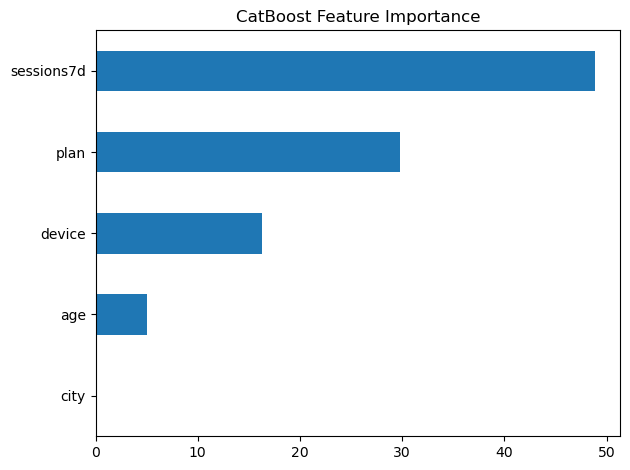

In [139]:
# 5)특성 중요도
import matplotlib.pyplot as plt
imp = model.get_feature_importance(test_pool)
pd.Series(imp, index=df.columns).sort_values().plot(kind="barh", title="CatBoost Feature Importance")
plt.tight_layout(); plt.show()

### 지금까지 머신러닝 모델들 많이 배우고 있는데 (딥러닝은 아직)
### 성능욕심이 더있어서? -> 딥러닝